In [329]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [633]:
from src.data_loader import ViTDataLoader
from src.vit_train import load_model_dir, ViTTrainer
from src.vit_data import load_cd_data_24x128_p1

model_dir = 'output/cd_fix_24x128_2chan_p1_logfold_20220816_b1f0'

vit, config = load_model_dir(model_dir, legacy=False)
vit_data = load_cd_data_24x128_p1(config.REPLICATE_MODE, config.CHANNEL_1, config.PREDICT_TPM)
config_name = "lfc"

dataloader = ViTDataLoader(vit_data, split_type=config.SPLIT_TYPE, split_arg=config.SPLIT_ARG, 
                           valid_type=config.VALIDATION_TYPE, valid_arg=config.VALIDATION_ARG)
print(dataloader.split_repr())

trainer = ViTTrainer(vit, config_name, dataloader, resume=True, resume_path=model_dir)


Split: time,120; Training: 17708; Validation: 0; Testing: 4427


In [648]:
trainer.setup()

Resuming from 320...


In [1111]:
trainer.compute_predictions_losses()

Computing test predictions...Done. 0.377, 0.803
00:01:10.28
Computing train predictions...Done. 0.349, 0.658
00:05:58.20
Computing validation predictions...Done. nan, nan
00:05:58.20


In [1112]:
print(trainer.perf_str)

Loss:
  Train:	0.349
  Valid:	nan
  Test: 	0.377

R2:
  Train:	0.658
  Valid:	nan
  Test: 	0.803


0

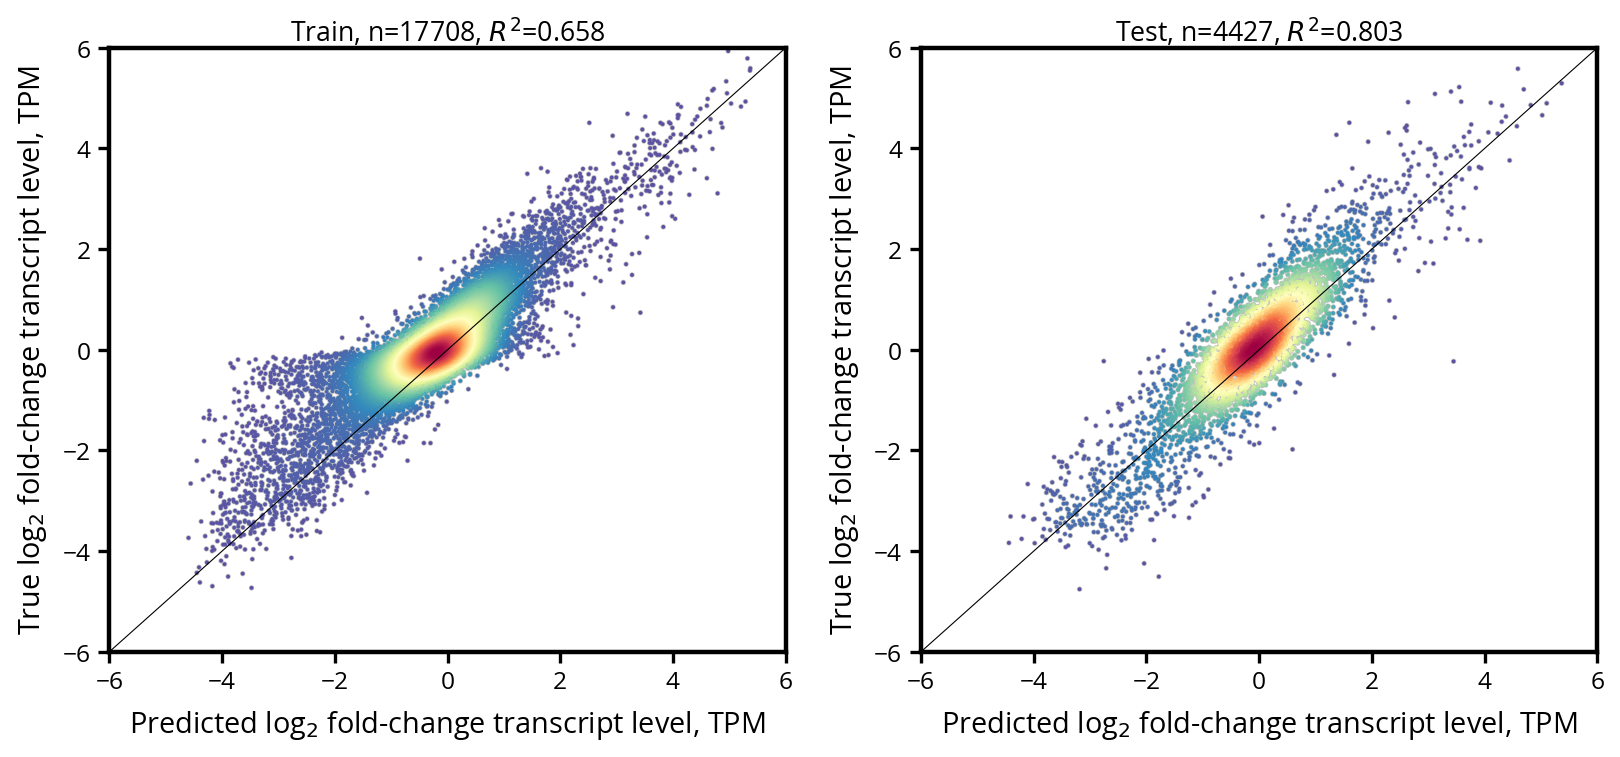

In [1118]:
trainer.plot_predictions()
0

In [1010]:
from src.rna_plotter import load_rna_plotter
from src.orf_plotter import ORFAnnotationPlotter

orf_plotter = ORFAnnotationPlotter()
rna_plotter = load_rna_plotter()
trainer.orf_plotter = orf_plotter
trainer.rna_plotter = rna_plotter


0

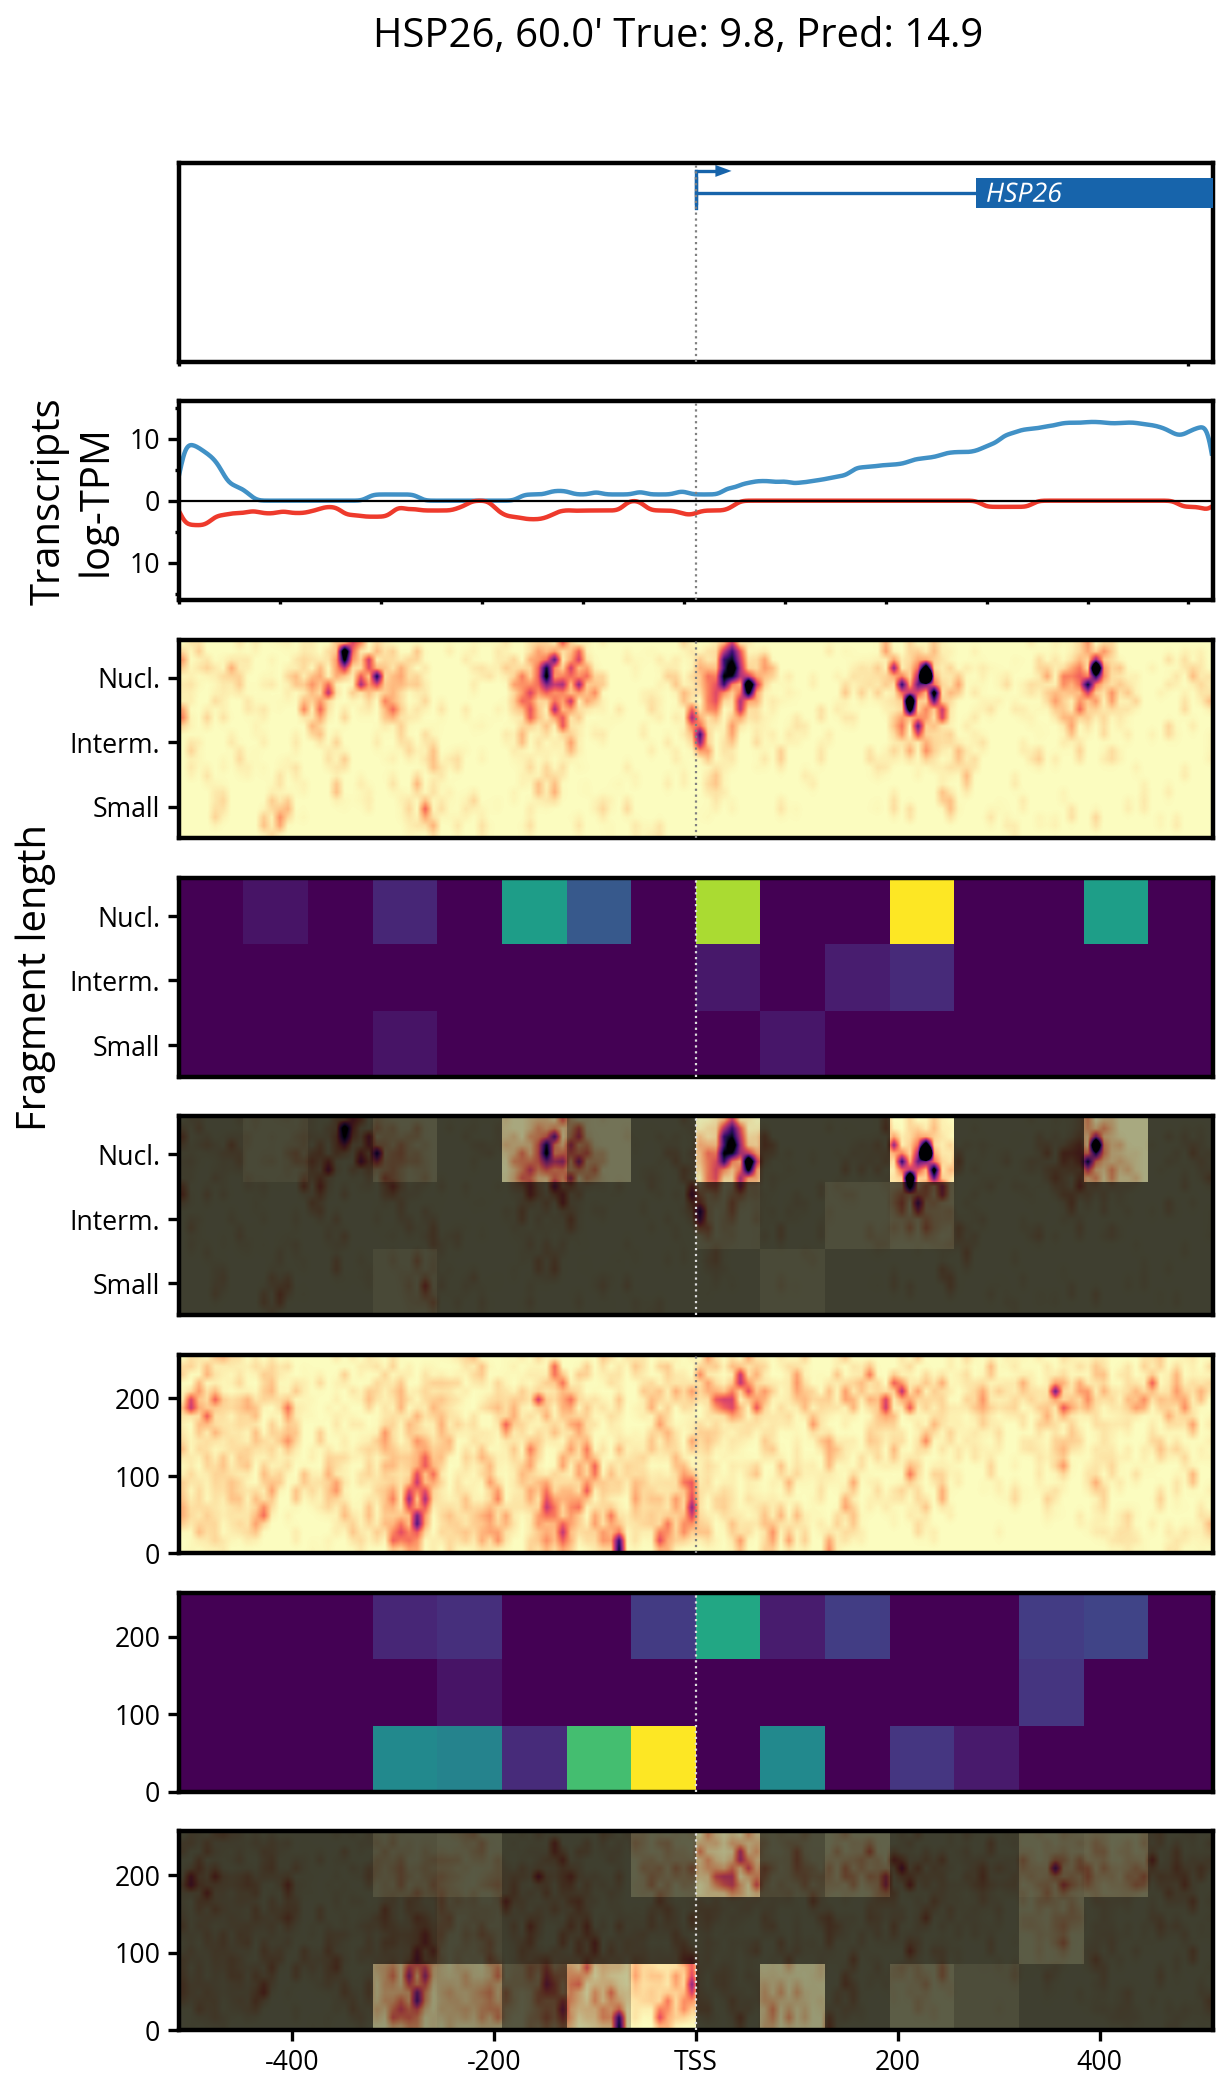

In [1013]:
from src.vit_viz import plot_gene_prediction

trainer.plot_gene('HSP26', 60)
0

In [916]:
from src.attention_analysis import AttentionAnalysis

a_analysis = AttentionAnalysis(trainer=trainer)

In [637]:
a_analysis.compute_attentions(t=None)

1/22135 - 00:00:00.24
1001/22135 - 00:03:35.77
2001/22135 - 00:07:39.67
3001/22135 - 00:11:13.56
4001/22135 - 00:15:04.10
5001/22135 - 00:18:38.68
6001/22135 - 00:22:32.88
7001/22135 - 00:26:50.12
8001/22135 - 00:31:00.45
9001/22135 - 00:35:14.48
10001/22135 - 00:39:25.30
11001/22135 - 00:43:35.10
12001/22135 - 00:47:48.35
13001/22135 - 00:51:58.57
14001/22135 - 00:56:21.35
15001/22135 - 01:00:40.33
16001/22135 - 01:14:19.78
17001/22135 - 01:28:08.43
18001/22135 - 01:41:43.49
19001/22135 - 01:45:23.37
20001/22135 - 01:48:56.39
21001/22135 - 01:52:33.59
22001/22135 - 01:56:18.05


In [649]:
from src.utils import write_pickle
write_pickle(a_analysis.trainer.collected_attentions,
            f"{a_analysis.trainer.out_dir}/collected_attentions_all.pkl")

Wrote output/cd_fix_24x128_2chan_p1_logfold_20220816_b1f0/collected_attentions_all.pkl


In [918]:
a_analysis.compute_umap(t=60)

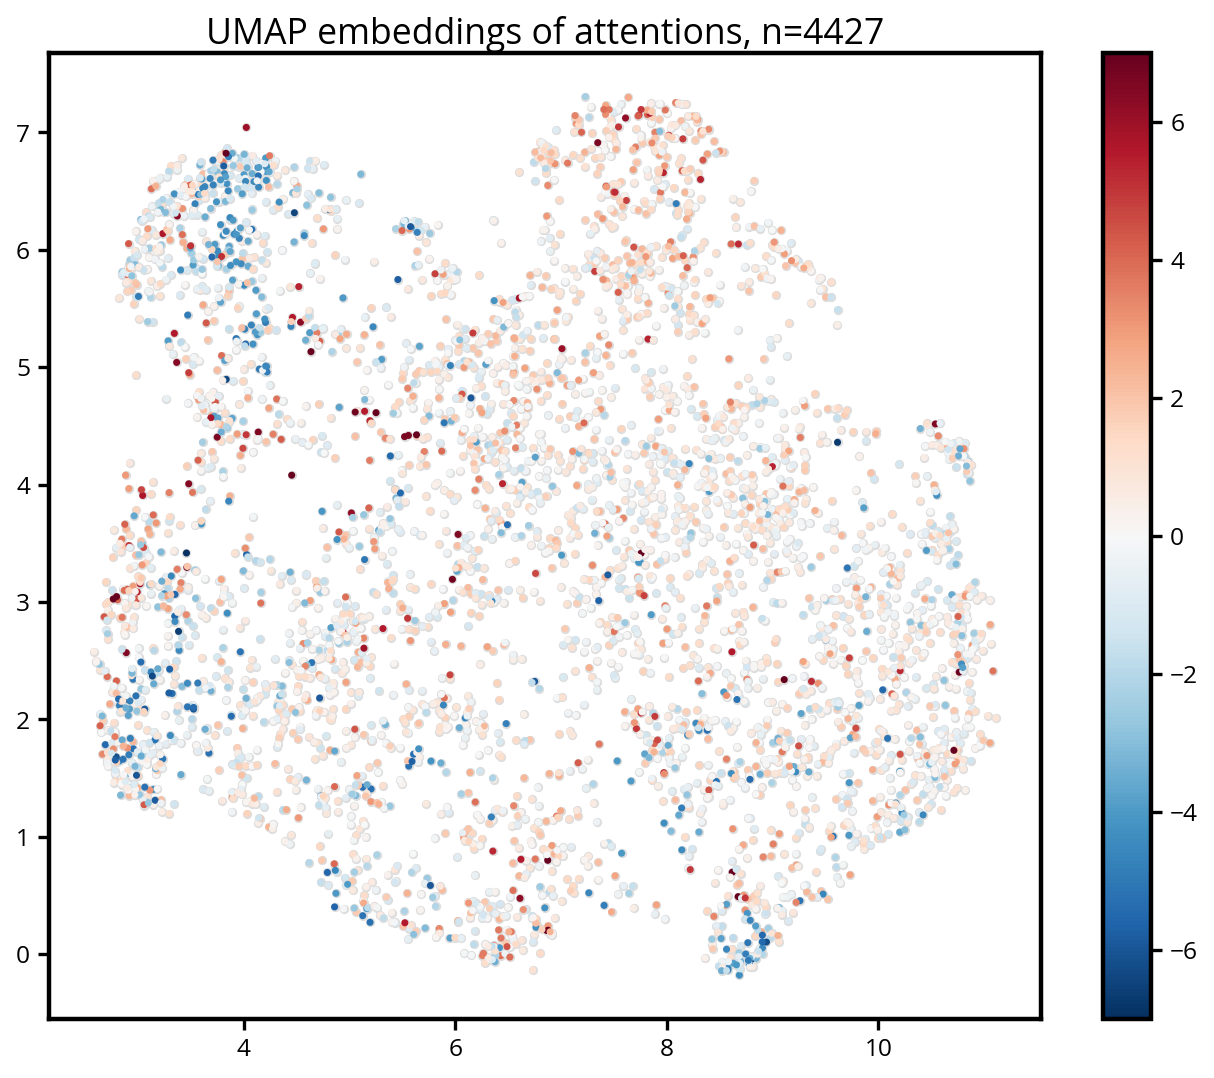

In [1065]:
a_analysis.plot_umap(t=60, ascending=None)

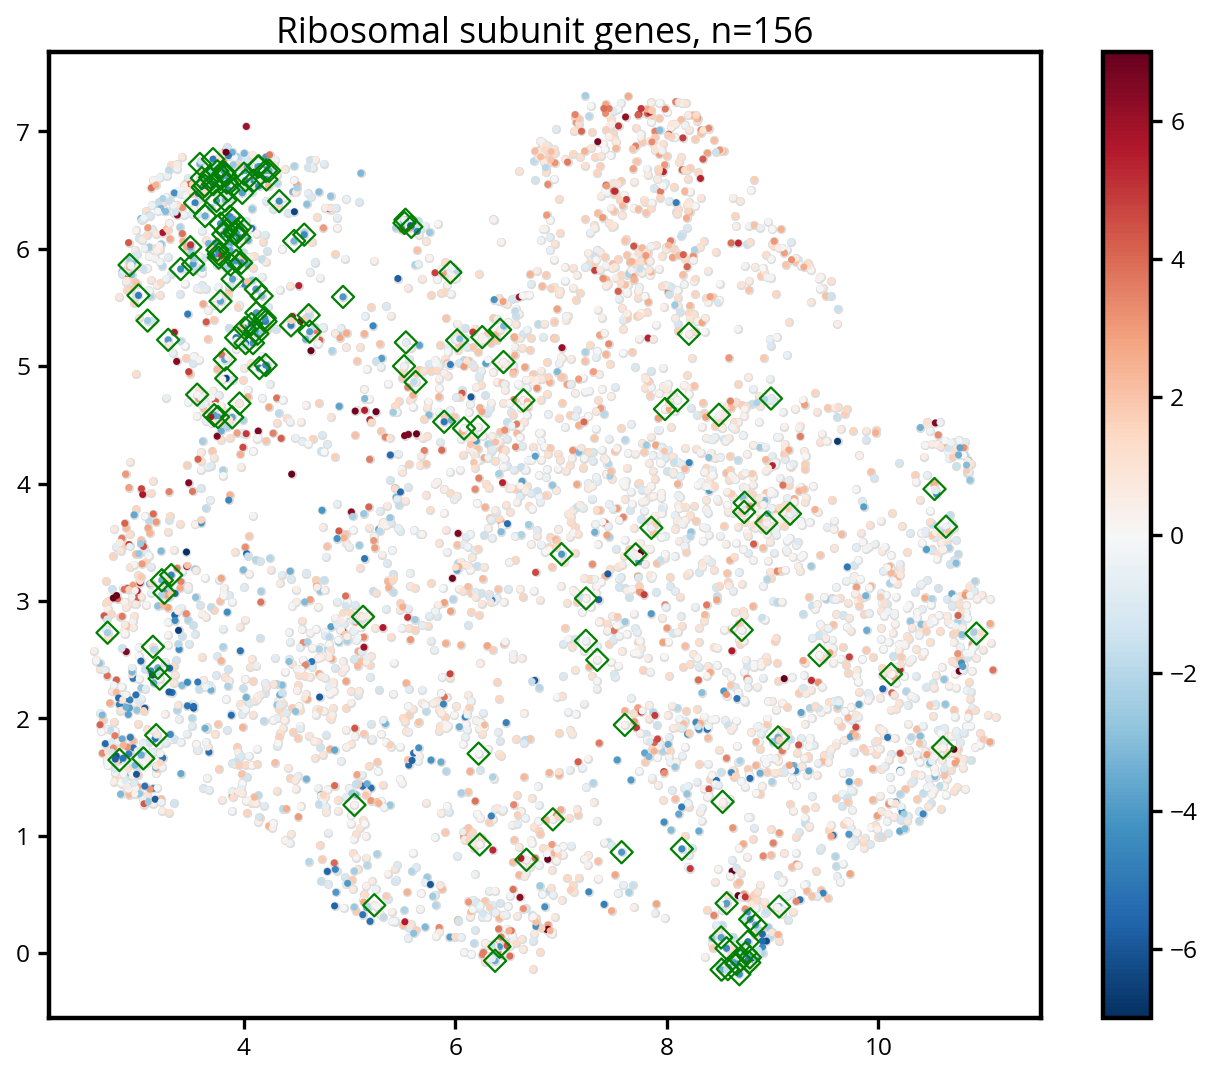

In [1066]:
a_analysis.plot_umap(t=60, selected_orfs=ribosomal_orfs, ascending=None, title="Ribosomal subunit genes")

In [994]:
a_analysis.load_rossi()

In [1218]:
a_analysis.compute_rossi_dispersion()

0/329 - 00:00:00.09
60/329 - 00:00:03.93
120/329 - 00:00:08.15
180/329 - 00:00:12.26
240/329 - 00:00:19.73
300/329 - 00:00:31.64


Text(0.5, 1.0, 'Mean sq. diff')

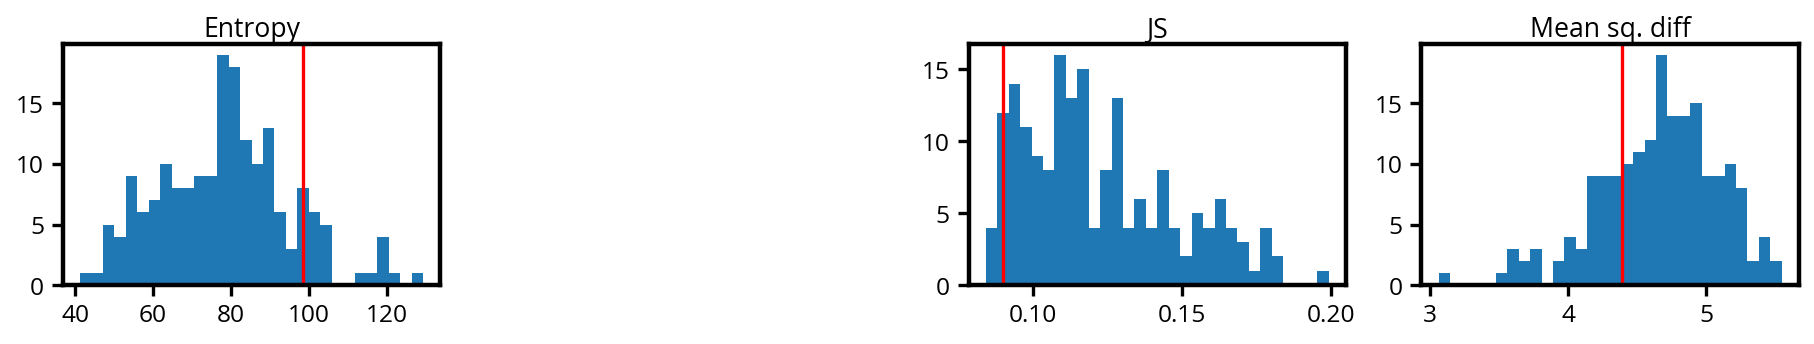

In [1271]:
cur_dispersions = dispersions[dispersions.n > 20].copy()
cur_dispersions.entropy = -cur_dispersions.entropy

plt.figure(figsize=(14, 2))
plt.subplot(1, 4, 1)
plt.hist(cur_dispersions.entropy, bins=30)
plt.axvline(cur_dispersions.loc['Null'].entropy, c='red')
plt.title("Entropy")

plt.subplot(1, 4, 3)
plt.hist(cur_dispersions.js, bins=30)
plt.axvline(cur_dispersions.loc['Null'].js, c='red')
plt.title("JS")

plt.subplot(1, 4, 4)
plt.hist(cur_dispersions.mean_squared_euclidean, bins=30)
plt.axvline(cur_dispersions.loc['Null'].mean_squared_euclidean, c='red')
plt.title("Mean sq. diff")


In [1272]:
cur_dispersions.loc[['Null']]

js  mean_euclidean  mean_squared_euclidean      n    entropy  \
Null  0.090109        2.053484                4.391994  100.0  98.405705   

      entropy_difference  absolute_entropy_difference  
Null                 0.0                          0.0

In [1273]:
cur_dispersions[cur_dispersions.n > 40].sort_values('entropy')[['entropy', 'n']].head(5)

entropy      n
Met4  49.657809   46.0
Ies3  54.624152   48.0
Nut1  57.789409   45.0
Yta7  59.794506  363.0
Stb5  60.183600   42.0

In [1274]:
cur_dispersions[cur_dispersions.n > 40].sort_values('entropy')[['entropy', 'n']].tail(5)

entropy      n
Vps71  119.490180  180.0
Swr1   119.572946  108.0
Bdf1   119.582116  517.0
Aor1   122.942525   41.0
Swc7   129.281405  112.0

In [1080]:
def plot_tf_metric_umap(cur_dispersions, metric, tf):
    selected_orfs = orfs_for_rossi_tf(vit_data.orfs_data, rossi_w_targets, tf)

    a_analysis.plot_umap(t=60, selected_orfs=selected_orfs, ascending=None, 
                         title=f"{tf}, {metric}={cur_dispersions.loc[tf][metric]:.2f}")


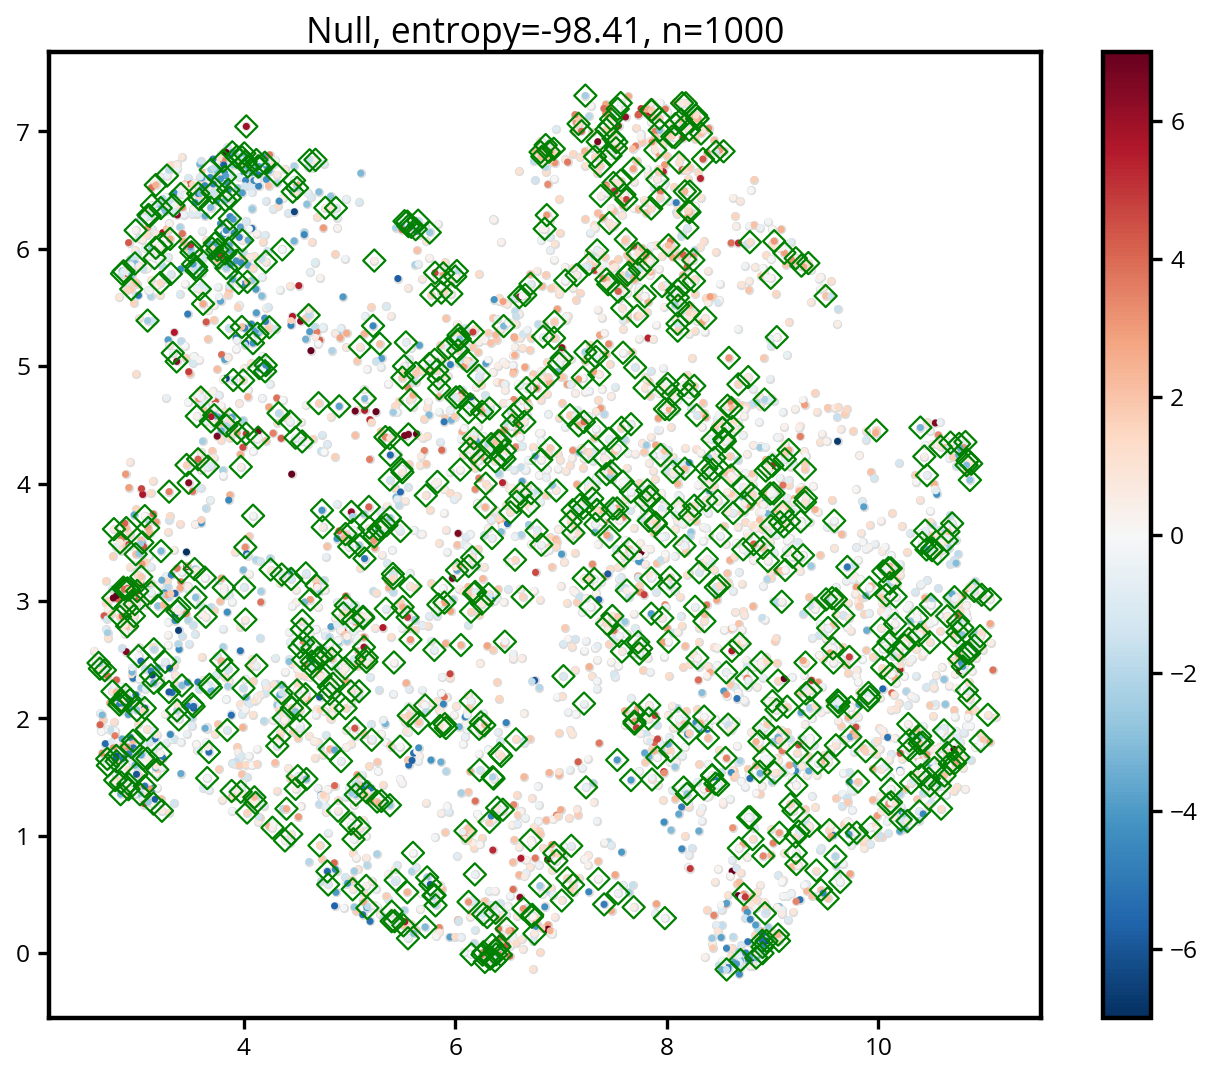

In [1265]:
tf = 'Null'
metric = 'entropy'
selected_orfs = a_analysis.null_orfs[-500:].flatten()

a_analysis.plot_umap(t=60, selected_orfs=selected_orfs, ascending=None, 
                     title=f"{tf}, {metric}={cur_dispersions.loc[tf][metric]:.2f}")


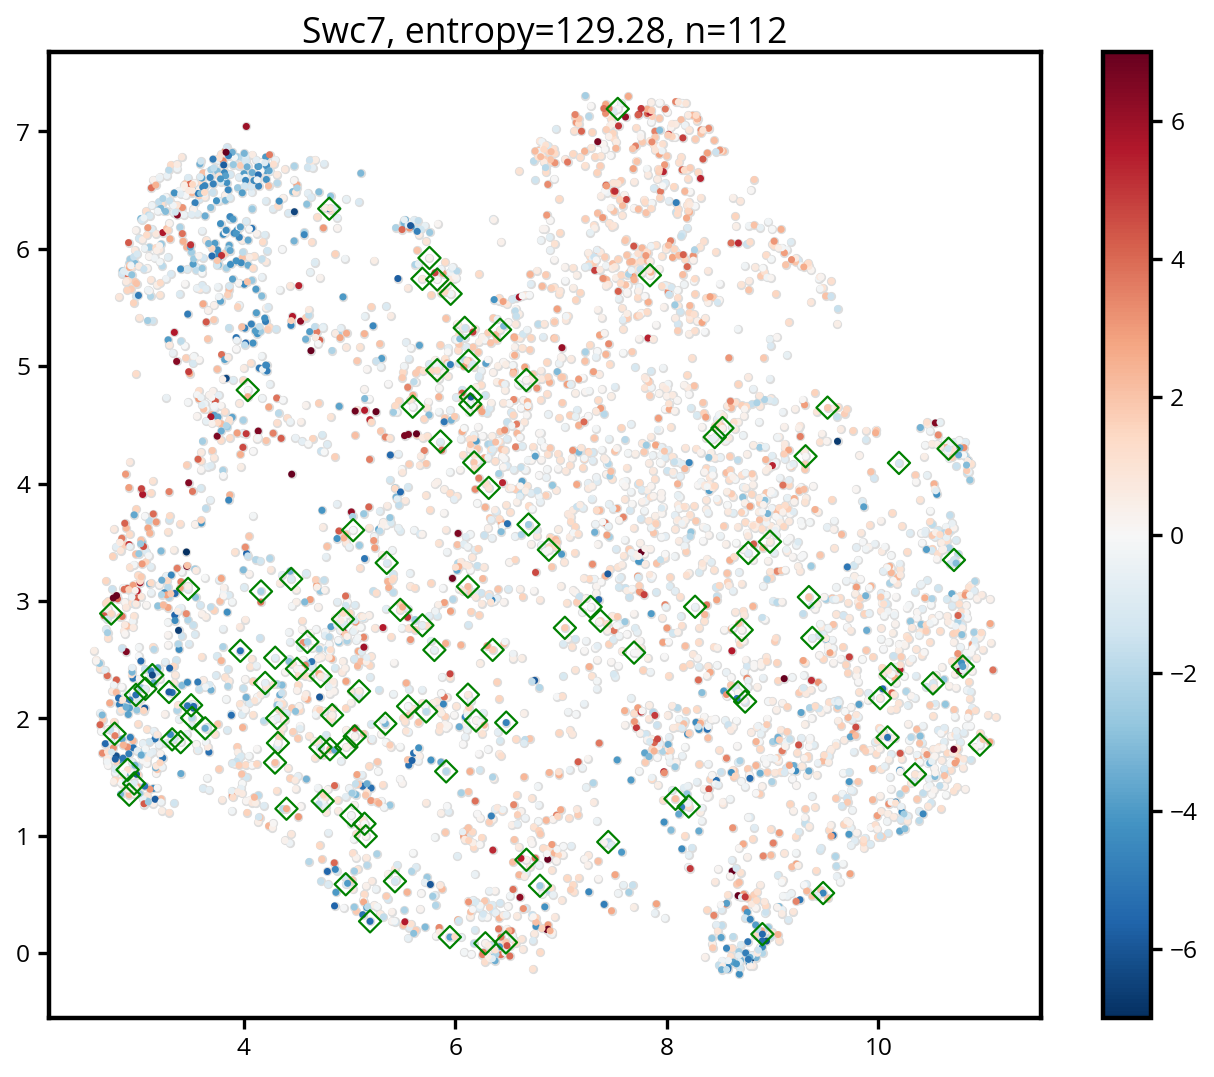

In [1275]:
plot_tf_metric_umap(cur_dispersions, 'entropy', 'Swc7')

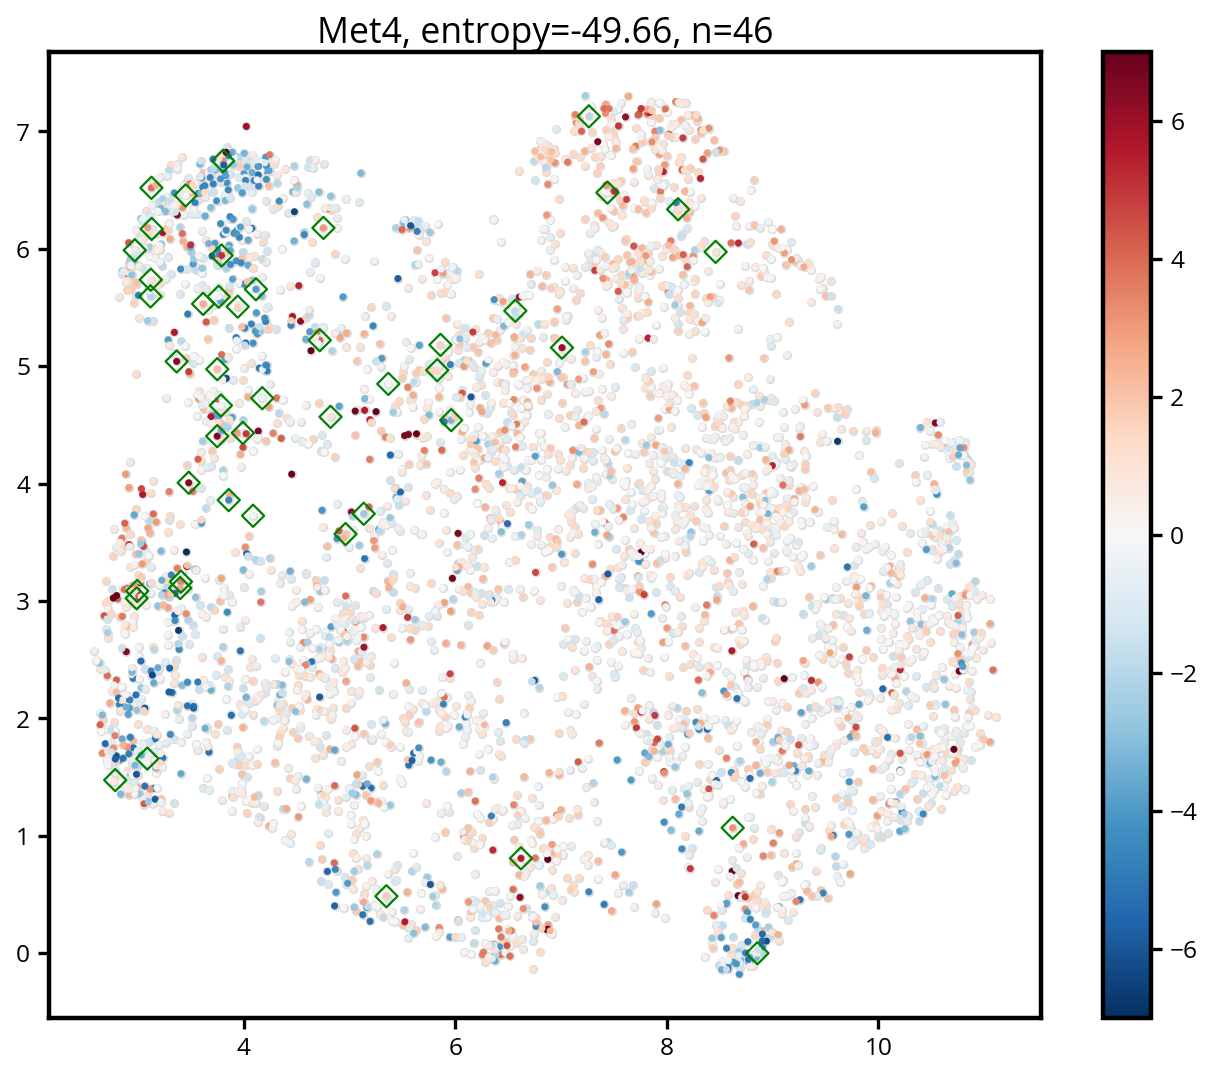

In [1266]:
plot_tf_metric_umap(cur_dispersions, 'entropy', 'Met4')